In [1]:
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from dataset import T_Dataset
from util import EDMLoss,AverageMeter
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from UNet import UNet, UNetWithASPP
from FCN import  FCN, FCNWithASPP


def adjust_learning_rate(params, optimizer, epoch):
    lr = params.init_lr * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def criterion_s(inputs, target):
    losses = nn.functional.cross_entropy(inputs, target, ignore_index=255)
    return losses

def create_data_part(opt):
    train_csv_path =  'train_half.csv'
    val_csv_path = 'valid.csv'
    test_csv_path = 'valid.csv'

    train_ds = T_Dataset(train_csv_path, opt.path_to_images, if_train = True )
    val_ds = T_Dataset(val_csv_path, opt.path_to_images, if_train = False )
    test_ds = T_Dataset(test_csv_path, opt.path_to_images, if_train=False )

    train_loader = DataLoader(train_ds, batch_size=opt.batch_size, num_workers=opt.num_workers, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=int(opt.batch_size/2), num_workers=opt.num_workers, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_ds, batch_size=opt.batch_size, num_workers=opt.num_workers, shuffle=False, drop_last=True)

    return train_loader, val_loader,test_loader

def train(opt,model, loader, optimizer, criterion, writer=None, global_step=None, name=None):
    model.train()
    train_losses = AverageMeter()

    for idx, (x,  mask) in enumerate(tqdm(loader)):
        x = x.to(opt.device)
        mask = mask.long()
        mask=mask.to(opt.device)
        pred = model(x)
        loss=criterion(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.update(loss.item(), x.size(0))
    print("train loss(target_img-pred):", train_losses.avg)

    return train_losses.avg

def validate(opt,model, loader, criterion, writer=None, global_step=None, name=None):
    model.eval()
    validate_losses = AverageMeter()
    true_score = []
    pred_score = []
    Ssim = 0
    psnr_value = 0
    flag=0

    for idx, (x, mask) in enumerate(tqdm(loader)):
        x = x.to(opt.device)
        mask = mask.long()
        mask = mask.to(opt.device)

        pred = model(x)
        loss = criterion(pred, mask)
        validate_losses.update(loss.item(), x.size(0))


    print("val loss:",validate_losses.avg)
    return validate_losses.avg, 0, 0, 0


def start_train(opt):

    train_loader, val_loader, test_loader = create_data_part(opt)

    model = FCN()
    model_path = 'ckpt/FCN_epoch_6_train_loss_0.48018698276895466_val_loss0.4734071700049819.pth'
    model.load_state_dict(torch.load(model_path, map_location='cuda:0'))

    optimizer = torch.optim.Adam(model.parameters(), lr=opt.init_lr)
    criterion = criterion_s
    #criterion.to(opt.device)
    model = model.to(opt.device)
    writer = None

    for e in range(1):
        adjust_learning_rate(opt, optimizer, e)
        train_loss = train(opt, model=model, loader=train_loader,
                           optimizer=optimizer, criterion=criterion,
                           writer=writer, global_step=len(train_loader) * e,
                           name="train_by_batch")
        val_loss, vacc, ssim_val, psnr_val = validate(opt, model=model,
                                               loader=val_loader, criterion=criterion,
                                               writer=writer, global_step=len(val_loader) * e,
                                               name="by_batch")

        model_name = f"FCN_epoch_{e}_train_loss_{train_loss}_val_loss{val_loss}.pth"
        torch.save(model.state_dict(),  model_name)


In [2]:
print("_"*100)
import easydict
option = easydict.EasyDict({
    "batch_size": 100,
    "train_steps": 1000,

    'path_to_images':'D:/turtles-data/data/',

    'init_lr':0.00003,
    'num_epoch':100,
    'batch_size':16,
    'num_workers':0,
    'gpu_id':'0'
})

____________________________________________________________________________________________________


In [3]:
import warnings
f = open('log_test.txt', 'w')
opt = option
opt.device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

start_train(opt)


100%|██████████| 165/165 [02:15<00:00,  1.22it/s]


train loss(target_img-pred): 0.4647712469100952


100%|██████████| 139/139 [00:59<00:00,  2.35it/s]


val loss: 0.46232186005913095


AttributeError: 'NoneType' object has no attribute 'close'

In [4]:

def start_train(opt):

    train_loader, val_loader, test_loader = create_data_part(opt)

    model = FCNWithASPP()
    model_path = 'ckpt/FCNWithASPP_epoch_6_train_loss_0.3181816271760247_val_loss0.3049879584381049.pth'
    model.load_state_dict(torch.load(model_path, map_location='cuda:0'))

    optimizer = torch.optim.Adam(model.parameters(), lr=opt.init_lr)
    criterion = criterion_s
    #criterion.to(opt.device)
    model = model.to(opt.device)
    writer = None

    for e in range(1):
        adjust_learning_rate(opt, optimizer, e)
        train_loss = train(opt, model=model, loader=train_loader,
                           optimizer=optimizer, criterion=criterion,
                           writer=writer, global_step=len(train_loader) * e,
                           name="by_batch")
        val_loss, vacc, ssim_val, psnr_val = validate(opt, model=model,
                                               loader=val_loader, criterion=criterion,
                                               writer=writer, global_step=len(val_loader) * e,
                                               name="_by_batch")

        model_name = f"FCNWithASPP_epoch_{e}_train_loss_{train_loss}_val_loss{val_loss}.pth"
        torch.save(model.state_dict(), model_name)


print("_" * 100)
import easydict
import warnings

option = easydict.EasyDict({
    "batch_size": 100,
    "train_steps": 1000,

    'path_to_images': 'D:/turtles-data/data/',

    'init_lr': 0.00003,
    'num_epoch': 100,
    'batch_size': 16,
    'num_workers': 0,
    'gpu_id': '0'
})
#import warnings
f = open('log_test.txt', 'w')
opt = option
opt.device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

start_train(opt)

____________________________________________________________________________________________________


100%|██████████| 165/165 [02:16<00:00,  1.21it/s]


train loss(target_img-pred): 0.30759138067563374


100%|██████████| 139/139 [00:57<00:00,  2.41it/s]


val loss: 0.29599348273423076


In [6]:
def calculate_iou(pred_tensor, gt_tensor, class_label):
    pred_mask = (pred_tensor == class_label)
    gt_mask = (gt_tensor == class_label)

    intersection = torch.logical_and(pred_mask, gt_mask).sum().item()
    union = torch.logical_or(pred_mask, gt_mask).sum().item()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou

def quantize_tensor(tensor):
    quantized_tensor = torch.round(tensor).int()

    quantized_tensor = torch.clamp(quantized_tensor, min=0, max=3)

    return quantized_tensor

model = FCNWithASPP()
model_path = 'ckpt/FCNWithASPP_epoch_6_train_loss_0.3181816271760247_val_loss0.3049879584381049.pth'
model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
model = model.to(opt.device)

IoU_1 = 0
IoU_2 = 0
IoU_3 = 0
flag = 0

train_loader, val_loader, test_loader = create_data_part(opt)

model.eval()
for idx, (x, mask) in enumerate(tqdm(val_loader)):
    x = x.to(opt.device)
    mask = mask.to(opt.device)
    pred = model(x)
    pred = pred.argmax(1)
    flag = flag+1
    for i in range(x.shape[0]):
        IoU_1 = IoU_1 + calculate_iou(quantize_tensor(pred[i]), mask[i], class_label=1)
        IoU_2 = IoU_2 + calculate_iou(quantize_tensor(pred[i]), mask[i], class_label=2)
        IoU_3 = IoU_3 + calculate_iou(quantize_tensor(pred[i]), mask[i], class_label=3)

IoU_1 = IoU_1/(flag*x.shape[0])
IoU_2 = IoU_2/(flag*x.shape[0])
IoU_3 = IoU_3/(flag*x.shape[0])


print("head IoU：", IoU_1)
print("flippers IoU：", IoU_2)
print("carapace IoU：", IoU_3)


100%|██████████| 139/139 [01:00<00:00,  2.31it/s]

head IoU： 0.41260688526139205
flippers IoU： 0.012143616527237045
carapace IoU： 0.02877697841726619


  0%|          | 0/139 [00:00<?, ?it/s]

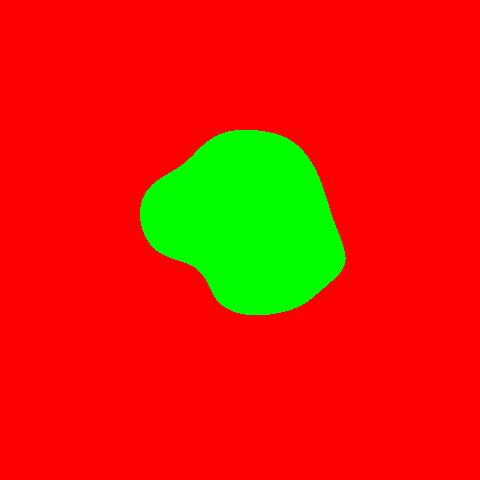

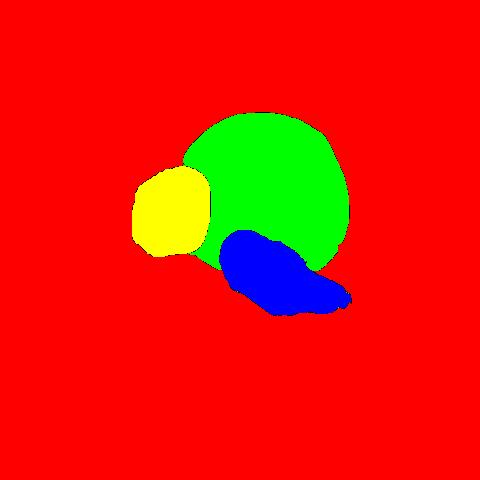

  0%|          | 0/139 [00:00<?, ?it/s]


In [7]:
from PIL import Image
import numpy as np

def show_color_img(img, image_name, param=1):
    img = img * param
    # print("img shape:", img.shape)
    tensor_np = img.numpy()

    color_map = {
        0: (255, 0, 0),  # red
        1: (0, 255, 0),  # green
        2: (0, 0, 255),  # blue
        3: (255, 255, 0)  # yellow
    }

    color_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for value, color in color_map.items():
        color_image[tensor_np == value] = color

    image = Image.fromarray(color_image)
    image.save(image_name)
    display(Image.open(image_name))

model.eval()
for idx, (x, mask) in enumerate(tqdm(val_loader)):
    x = x.to(opt.device)
    mask = mask.to(opt.device)
    pred = model(x)
    pred = pred.argmax(1)
    show_color_img(pred[0].detach().cpu(), 'pred.jpg')
    show_color_img(mask[0].detach().cpu(), 'label.jpg')
    break

In [8]:
model = FCN()
model_path = 'ckpt/FCN_epoch_6_train_loss_0.48018698276895466_val_loss0.4734071700049819.pth'
model.load_state_dict(torch.load(model_path, map_location='cuda:0'))
model = model.to(opt.device)

IoU_1 = 0
IoU_2 = 0
IoU_3 = 0
flag = 0

train_loader, val_loader, test_loader = create_data_part(opt)

model.eval()
for idx, (x, mask) in enumerate(tqdm(val_loader)):
    x = x.to(opt.device)
    mask = mask.to(opt.device)
    pred = model(x)
    pred = pred.argmax(1)
    flag = flag+1
    for i in range(x.shape[0]):
        IoU_1 = IoU_1 + calculate_iou(quantize_tensor(pred[i]), mask[i], class_label=1)
        IoU_2 = IoU_2 + calculate_iou(quantize_tensor(pred[i]), mask[i], class_label=2)
        IoU_3 = IoU_3 + calculate_iou(quantize_tensor(pred[i]), mask[i], class_label=3)

IoU_1 = IoU_1/(flag*x.shape[0])
IoU_2 = IoU_2/(flag*x.shape[0])
IoU_3 = IoU_3/(flag*x.shape[0])


print("head IoU：", IoU_1)
print("flippers IoU：", IoU_2)
print("carapace IoU：", IoU_3)

100%|██████████| 139/139 [01:01<00:00,  2.25it/s]

head IoU： 0.0008992805755395684
flippers IoU： 0.011690647482014389
carapace IoU： 0.02877697841726619


  0%|          | 0/139 [00:00<?, ?it/s]

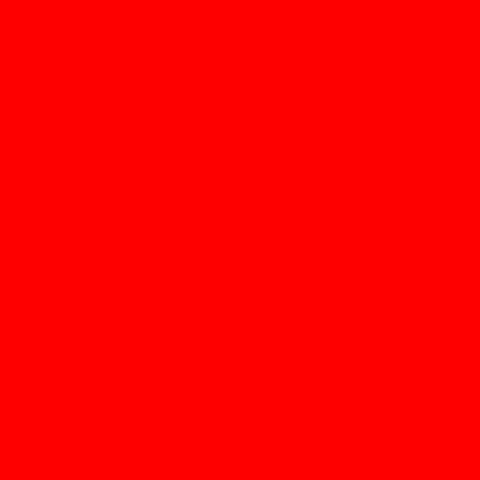

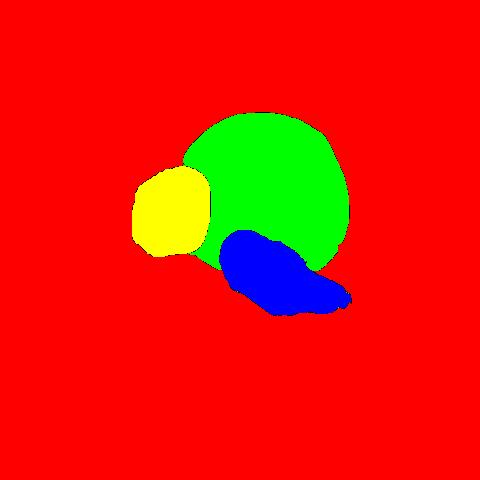

  0%|          | 0/139 [00:00<?, ?it/s]


In [9]:
from PIL import Image
import numpy as np

def show_color_img(img, image_name, param=1):
    img = img * param
    # print("img shape:", img.shape)
    tensor_np = img.numpy()

    color_map = {
        0: (255, 0, 0),  # red
        1: (0, 255, 0),  # green
        2: (0, 0, 255),  # blue
        3: (255, 255, 0)  # yellow
    }

    color_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for value, color in color_map.items():
        color_image[tensor_np == value] = color

    image = Image.fromarray(color_image)
    image.save(image_name)
    display(Image.open(image_name))

model.eval()
for idx, (x, mask) in enumerate(tqdm(val_loader)):
    x = x.to(opt.device)
    mask = mask.to(opt.device)
    pred = model(x)
    pred = pred.argmax(1)
    show_color_img(pred[0].detach().cpu(), 'pred.jpg')
    show_color_img(mask[0].detach().cpu(), 'label.jpg')
    break